In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import _LRScheduler

import math
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PatchEmbedding(nn.Module):
    """
    이미지를 패치로 분할하고, 각 패치를 임베딩하는 클래스입니다.

    Attributes:
    patch_size (int): 패치의 크기 (예: 16x16).
    n_patches (int): 이미지당 생성되는 패치의 총 수.
    projection (nn.Conv2d): 패치를 임베딩 벡터로 변환하는 컨볼루션 레이어.

    Args:
    img_size (int): 입력 이미지의 크기 (예: 32x32).
    patch_size (int): 패치의 크기 (예: 16x16).
    in_channels (int): 입력 이미지의 채널 수 (RGB의 경우 3).
    embed_dim (int): 임베딩 차원의 크기.
    """
    def __init__(self, img_size:int=32, patch_size:int=2, in_channels:int=3, embed_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # 컨볼루션을 사용하여 패치를 임베딩 벡터로 변환
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: [배치 크기, 채널 수, 높이, 너비]
        x = self.projection(x)  # 컨볼루션을 통한 임베딩: [배치 크기, 임베딩 차원, 패치 수, _]
        x = x.flatten(2)        # 평탄화: [배치 크기, 임베딩 차원, 패치 수]
        x = x.transpose(1, 2)   # 변환: [배치 크기, 패치 수, 임베딩 차원]
        return x

In [3]:
class PositionalEncoding(nn.Module):
    """
    위치 인코딩을 추가하는 클래스입니다. 각 패치에 대한 위치 정보를 제공합니다.

    Attributes:
    position_embedding (torch.nn.Parameter): 학습 가능한 위치 인코딩.

    Args:
    num_patches (int): 이미지당 생성되는 패치의 수.
    embed_dim (int): 임베딩 차원의 크기.
    """
    def __init__(self, num_patches:int, embed_dim:int):
        super().__init__()
        self.position_embedding = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

    def forward(self, x):
        x += self.position_embedding  # 위치 정보를 임베딩에 더함
        return x

In [4]:
class TransformerEncoderLayer(nn.Module):
    """
    Transformer Encoder 레이어를 정의하는 클래스입니다.

    Attributes:
    norm1, norm2 (nn.LayerNorm): 정규화 레이어.
    attn (nn.MultiheadAttention): 멀티헤드 어텐션 레이어.
    mlp (nn.Sequential): 피드포워드 네트워크.

    Args:
    embed_dim (int): 임베딩 차원의 크기.
    num_heads (int): 멀티헤드 어텐션에서의 헤드 수.
    mlp_ratio (float): 첫 번째 선형 레이어의 출력 차원을 결정하는 비율.
    dropout (float): 드롭아웃 비율.
    """
    def __init__(self, embed_dim:int, num_heads:int, mlp_ratio:float=4.0, dropout:float=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout) # -> [attention_output, attention weights]

        mlp_hidden_dim = int(mlp_ratio * embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
        )

    def forward(self, x):
        # 멀티헤드 어텐션과 피드포워드 네트워크를 적용
        x2 = self.norm(x)
        x = x + self.attn(x2, x2, x2)[0]
        x2 = self.norm(x)
        x = x + self.ff(x2)
        return x

In [5]:
class VisionTransformer(nn.Module):
    """
    전체 Vision Transformer 모델을 정의하는 클래스입니다.

    Attributes:
    patch_embed (PatchEmbedding): 이미지를 패치로 분할하고 임베딩하는 레이어.
    pos_embed (PositionalEncoding): 위치 인코딩 레이어.
    transformer_encoders (nn.ModuleList): Transformer Encoder 레이어들의 리스트.
    norm (nn.LayerNorm): 정규화 레이어.
    head (nn.Linear): 최종 분류를 위한 선형 레이어.

    Args:
    img_size (int): 입력 이미지의 크기 (예: 32x32).
    patch_size (int): 패치의 크기 (예: 16x16).
    in_channels (int): 입력 이미지의 채널 수 (RGB의 경우 3).
    num_classes (int): 분류할 클래스의 수 (CIFAR-10의 경우 10).
    embed_dim (int): 임베딩 차원의 크기.
    num_heads (int): 멀티헤드 어텐션에서의 헤드 수.
    num_layers (int): Transformer Encoder 레이어의 수.
    mlp_ratio (float): 피드포워드 네트워크의 차원 확장 비율.
    dropout (float): 드롭아웃 비율.
    """
    def __init__(self, img_size:int=32, patch_size:int=4, in_channels:int=3, num_classes:int=100, embed_dim:int=768, num_heads:int=12, num_layers:int=12, mlp_ratio:float=4., dropout:float=0.1):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches
        self.pos_embed = PositionalEncoding(num_patches, embed_dim)

        self.transformer_encoders = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout) 
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)  # 이미지를 패치로 분할하고 임베딩
        x = self.pos_embed(x)    # 위치 인코딩 적용

        for layer in self.transformer_encoders:
            x = layer(x)  # 각 Transformer Encoder 레이어 적용

        x = self.norm(x)        # 정규화
        x = x.mean(dim=1)       # 글로벌 평균 풀링
        x = self.head(x)        # 최종 분류를 위한 선형 레이어
        return x

In [6]:
# 모델 테스트
test_img = torch.randn(2, 3, 32, 32)  # 임의의 이미지 데이터 생성 (Batch x Channel x Width x Height)

vit = VisionTransformer()  # 모델 초기화
output = vit(test_img)     # 테스트 이미지를 모델에 통과

output.shape  # 결과의 형태 확인 ([배치 크기, 클래스 수])

torch.Size([2, 100])

In [7]:
batch_size = 720
num_workers = 8
num_classes = 100

# label_smoothing = 0.1
learning_rate = 0.001
epochs = 80

device = 'cuda:2'
model_path = 'best_model.pth'  # 모델 저장 경로

In [8]:
# 데이터 증강을 위한 전처리
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변경
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
class WarmupCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            return [base_lr * self.last_epoch / self.warmup_steps for base_lr in self.base_lrs]
        else:
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (self.last_epoch - self.warmup_steps) / (self.total_steps - self.warmup_steps)))
            return [base_lr * cosine_decay for base_lr in self.base_lrs]

In [10]:
total_steps = len(trainloader) * epochs
warmup_steps = total_steps * 0.2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate, betas=[0.9,0.999], weight_decay=0.03)
# scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)
scheduler = WarmupCosineAnnealingLR(optimizer, warmup_steps, total_steps)

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Epoch 1: 100%|██████████| 70/70 [02:19<00:00,  1.99s/it]


	Loss: 4.528876059395927, Val Loss: 4.3248884337288995, LR: 6.25e-05, Duration: 149.62 sec - model saved!


Epoch 2: 100%|██████████| 70/70 [02:20<00:00,  2.01s/it]


	Loss: 4.228756856918335, Val Loss: 4.093024015426636, LR: 0.000125, Duration: 150.91 sec - model saved!


Epoch 3: 100%|██████████| 70/70 [02:20<00:00,  2.01s/it]


	Loss: 4.081765099934169, Val Loss: 4.020253726414272, LR: 0.0001875, Duration: 151.52 sec - model saved!


Epoch 4: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 4.008540119443621, Val Loss: 3.918247870036534, LR: 0.00025, Duration: 151.70 sec - model saved!


Epoch 5: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 3.9681585243770052, Val Loss: 3.928814649581909, LR: 0.0003125, Duration: 151.08 sec


Epoch 6: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 3.9398782048906598, Val Loss: 3.8408042192459106, LR: 0.000375, Duration: 152.07 sec - model saved!


Epoch 7: 100%|██████████| 70/70 [02:22<00:00,  2.04s/it]


	Loss: 3.8788157531193326, Val Loss: 3.815709267343794, LR: 0.0004375, Duration: 153.33 sec - model saved!


Epoch 8: 100%|██████████| 70/70 [02:21<00:00,  2.03s/it]


	Loss: 3.848267129489354, Val Loss: 3.8089419262749806, LR: 0.0005, Duration: 152.44 sec - model saved!


Epoch 9: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 3.8671838964734757, Val Loss: 3.8396211181368147, LR: 0.0005625, Duration: 151.30 sec


Epoch 10: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 4.30070480959756, Val Loss: 4.582899025508335, LR: 0.000625, Duration: 150.87 sec


Epoch 11: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 4.324959884371077, Val Loss: 4.199836765016828, LR: 0.0006875000000000001, Duration: 150.81 sec


Epoch 12: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 4.099600757871356, Val Loss: 3.9540430647986278, LR: 0.00075, Duration: 151.02 sec


Epoch 13: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 4.048030090332031, Val Loss: 4.171261889593942, LR: 0.0008125000000000001, Duration: 150.98 sec


Epoch 14: 100%|██████████| 70/70 [02:22<00:00,  2.04s/it]


	Loss: 4.038759241785322, Val Loss: 3.9343924862997874, LR: 0.000875, Duration: 152.51 sec


Epoch 15: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 3.9767554351261682, Val Loss: 4.016741326877049, LR: 0.0009375000000000001, Duration: 151.54 sec


Epoch 16: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 3.9819876398359026, Val Loss: 3.9383489745003835, LR: 0.001, Duration: 151.17 sec


Epoch 17: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 3.9873765332358224, Val Loss: 3.9138404641832625, LR: 0.0009993977281025862, Duration: 150.87 sec


Epoch 18: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


	Loss: 4.030890658923558, Val Loss: 4.1518374511173795, LR: 0.0009975923633360985, Duration: 150.86 sec
Early stopping


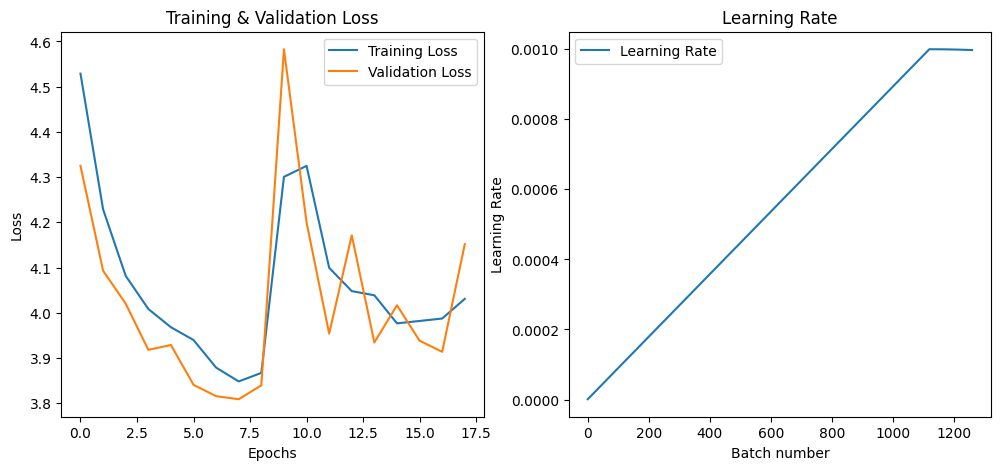

In [12]:
from tqdm import tqdm

training_time = 0
early_stopping = EarlyStopping(patience=10)
losses = []
val_losses = []
lrs = []
best_val_loss = float('inf')

vit_save = False
vit.to(device)

for epoch in range(epochs):
    vit.train()
    start_time = time.time()
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch + 1}")
    for i, data in pbar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        lr = optimizer.param_groups[0]["lr"]
        lrs.append(lr)
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # 검증 손실 계산
    vit.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = vit(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(testloader)
    val_losses.append(val_loss)

    # 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        vit_save = True
        torch.save(vit.state_dict(), model_path)

    epoch_duration = time.time() - start_time
    training_time += epoch_duration
    if vit_save:
        print(f'\tLoss: {epoch_loss}, Val Loss: {val_loss}, LR: {lr}, Duration: {epoch_duration:.2f} sec - model saved!')
        vit_save = False
    else :
        print(f'\tLoss: {epoch_loss}, Val Loss: {val_loss}, LR: {lr}, Duration: {epoch_duration:.2f} sec')

    # Early Stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Batch number')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Hook 함수 정의 및 등록
attention_maps = []
def get_attention_map(module, input, output):
    global attention_maps
    attention_maps.append(output[1].detach())
hook = vit.transformer_encoders[0].attn.register_forward_hook(get_attention_map)

# 모델을 통한 예측 및 Attention Map 추출
original_images, labels = next(iter(testloader))
outputs = vit(original_images.to(device))
_, predicted = torch.max(outputs, 1)
hook.remove()

# CIFAR-10 클래스 레이블
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Attention Map 가공 및 시각화 개선 함수
def show_attention_on_image(img, attention_map, label, pred, threshold=0.0):
    # 이미지 크기에 맞게 Attention Map 조정
    attention_map = attention_map.cpu().numpy()
    attention_map = attention_map - np.min(attention_map)
    attention_map = attention_map / np.max(attention_map)

    # 임계값 이하의 Attention 값 제거
    # attention_map[attention_map < threshold] = 0

    # 원본 이미지 크기로 Attention Map 업샘플링
    attention_map_resized = np.resize(attention_map, (img.shape[1], img.shape[2]))

    # 원본 이미지와 Attention Map 겹쳐서 표시
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].axis('off')
    axs[0].set_title(f'Original Image\nTrue Label: {label}')

    axs[1].imshow(img.permute(1, 2, 0))
    axs[1].imshow(attention_map_resized, cmap='jet', alpha=0.6)  # 투명도 조절
    axs[1].axis('off')
    axs[1].set_title(f'Image with Attention Map\nPredicted: {pred}')

    plt.show()

# 각 이미지에 대해 시각화 수행
for i in range(4):
    show_attention_on_image(original_images[i], attention_maps[0][i], classes[labels[i]], classes[predicted[i]])


IndexError: tuple index out of range